## Step 5: Model Evaluation

In this section, we seek the influence of different data processing methods on the model.

In dataset 1, we kick out unrelevant features and standarize numerical features.<br/>
In dataset 2, we discretize `LIMIT_BAL` in dataset 2.<br/>
In dataset 3, we add `Limit_Usage` and `Pay_Amt_std` to dataset 2.(Step 4)  
In dataset 4, we kick out `SEX` , `AGE_GROUP` and `MARRIAGE` according to IV-WOE analysis in Step 3.1.  

In [198]:
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn imports
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.metrics import recall_score, f1_score, precision_score
import scipy.stats as sta
from sklearn.model_selection import GridSearchCV


In [199]:
df = pd.read_csv('data_standardized.csv')
pd.set_option('display.max_columns', None)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,AGE_GROUP,LIMIT_BAL_GROUP,PAY_0_TEST,PAY_2_TEST,PAY_3_TEST,PAY_4_TEST,PAY_5_TEST,PAY_6_TEST,Limit_Usage,Pay_Amt_std
0,1,-1.138505,Female,University,Married,24,2,2,-1,-1,-2,-2,-0.641227,-0.646464,-0.667310,0,0,0,-0.355537,-0.234479,-0.307629,-0.313593,-0.316060,-0.293887,1,20s,0-50k,Delay,Delay,Paid,Paid,Paid,Paid,0.195650,2.449490
1,2,-0.369733,Female,University,Single,26,-1,2,0,0,0,2,-0.657978,-0.665835,-0.638545,3272,3455,3261,-0.355537,-0.220403,-0.248100,-0.248590,-0.316060,-0.180938,1,20s,100-150k,Paid,Delay,Paid,Paid,Paid,Delay,0.022350,0.903327
2,3,-0.600364,Female,University,Single,34,0,0,0,0,0,0,-0.296607,-0.492770,-0.481558,14331,14948,15549,-0.259775,-0.197774,-0.248100,-0.248590,-0.250175,-0.011514,0,30s,50-100k,Paid,Paid,Paid,Paid,Paid,Paid,0.324878,0.854864
3,4,-0.907873,Female,University,Married,37,0,0,0,0,0,0,-0.055062,-0.011556,0.034160,28314,28959,29547,-0.229369,-0.174285,-0.236195,-0.242089,-0.245629,-0.237412,0,30s,0-50k,Paid,Paid,Paid,Paid,Paid,Paid,0.939800,0.341959
4,5,-0.907873,Male,University,Married,57,-1,0,-1,0,0,0,-0.577218,-0.610337,-0.160050,20940,19146,19131,-0.229369,1.394468,0.287654,0.271442,-0.270665,-0.255541,0,50s,0-50k,Paid,Paid,Paid,Paid,Paid,Paid,0.172340,1.400826


In [200]:
def comparemodels():
    names = ["LogisticRegression",
            "Naive Bayes",
            "Decision Tree",
            "Random Forest"]
    classifiers = [LogisticRegression(solver = 'liblinear'),
                  GaussianNB(),
                  DecisionTreeClassifier(random_state=0),
                  RandomForestClassifier(random_state=0, bootstrap=True)]
    cmaps = ['Reds',
            'Greens',
            'Blues',
            'Oranges']
    fig, axe1 = plt. subplots(nrows=1, ncols=1, figsize=(8,4))
    fig, axe = plt. subplots(nrows=2, ncols=2, figsize=(8, 2*4))
    valuation = pd.DataFrame()

    LR_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    LR_param_grid = {'C': LR_param_range}
    
    NB_param_grid = {}
    
    DT_max_depth_range = [1, 5, 10, 15, 20, 25]
    DT_criterion_range = ['gini', 'entropy']
    DT_param_grid = {'criterion': DT_criterion_range, 'max_depth': DT_max_depth_range}
    
    RF_n_estimators_range = [10, 20, 30]
    RF_max_depth_range = [1, 5, 10, 15, 20, 25]
    RF_criterion_range = ['gini', 'entropy']
    RF_param_grid = {'n_estimators': RF_n_estimators_range, 'max_depth': RF_max_depth_range, 'criterion': RF_criterion_range}
    

    grids = [LR_param_grid,
            NB_param_grid,
            DT_param_grid,
            RF_param_grid]


    for name, clf, ax, cmap, param_grid in zip(names, classifiers, axe.ravel(), cmaps, grids):
        
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=10)
        grid_search.fit(X_train,y_train) 
        print("Test set score:{:.2f}".format(grid_search.score(X_test,y_test)))
        print("Best parameters:{}".format(grid_search.best_params_))
        print("Best score on train set:{:.2f}".format(grid_search.best_score_))          
        
        y_pred = grid_search.predict(X_test)    
        y_score = grid_search.predict_proba(X_test)[:, 1]
        
        score = grid_search.score(X_test, y_test)
        precision = round(precision_score(y_true=y_test, y_pred=y_pred),2)
        recall = round(recall_score(y_true=y_test, y_pred=y_pred),2)
        f1 = round(f1_score(y_true=y_test, y_pred=y_pred),2)
        temp = pd.DataFrame({
            'precision_score':[precision],
            'recall':[recall],
            'f1_score':f1
        },index = [name])
        
#         temp = pd.DataFrame([precision_score,recall,f1_score],columns = [clf])
        valuation = valuation.append(temp)
        #if(cmap == 'Oranges'):
           # tmp_fi = pd.Series(clf.feature_importances_)
        
        confmatrix = confusion_matrix(y_test, y_pred)
        true0, true1 = [sum(confmatrix[i]) for i in [0,1]]
        pred0, pred1 = [sum(i) for i in zip(*confmatrix)]
        #need to check whether tpr is right
        tpr=confmatrix[1,1]/true1
        
        ylabels = ['Not default: {}'.format(true0), 'Default: {}'.format(true1)]
        xlabels = ['Not default: {}'.format(pred0), 'Default: {}'.format(pred1)]

        
        sns.heatmap(confusion_matrix(y_test, y_pred),
                   annot = True,
                   xticklabels = xlabels,
                   yticklabels = ylabels,
                   fmt = 'g',
                   ax = ax,
                   vmax = len(X_test),
                   vmin = 0,
                   cbar = False,
                   cmap = cmap)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Truth')
        ax.set_title('{} (Score: {},TPR:{})'.format(name, np.round(score, decimals=3),np.round(tpr, decimals=3)), size=12)
        #ax.set_title('{} (Score: {})'.format(name, np.round(score, decimals=3)), size=14)
        fpr, tpr, thresholds = roc_curve(y_test, y_score, drop_intermediate=False, pos_label=1)
        axe1.set_ylabel('True Positive Rate')
        axe1.set_xlabel('False Positive Rate')
        
        axe1.plot([0,1], [0,1], c = 'black')
        axe1.set_title('AUC of Algorithms')
        roc_auc = auc(fpr, tpr)
        axe1.plot (fpr, tpr, label = 'ROC fold %s (area = %0.2f)' %(name, roc_auc))
        axe1.legend(prop={'size': 11}, loc = 'lower right')

    return fig, confmatrix, valuation

In [201]:
dataset1_dum=['SEX', 'MARRIAGE', 'EDUCATION','PAY_0_TEST','PAY_2_TEST', 'PAY_3_TEST', 'PAY_4_TEST', 'PAY_5_TEST','PAY_6_TEST']
dataset2_dum=['LIMIT_BAL_GROUP', 'SEX', 'MARRIAGE', 'EDUCATION','PAY_0_TEST','PAY_2_TEST', 'PAY_3_TEST', 'PAY_4_TEST', 'PAY_5_TEST','PAY_6_TEST']
dataset3_dum=['LIMIT_BAL_GROUP', 'SEX', 'MARRIAGE', 'EDUCATION','PAY_0_TEST','PAY_2_TEST', 'PAY_3_TEST', 'PAY_4_TEST', 'PAY_5_TEST','PAY_6_TEST']
dataset4_dum=['LIMIT_BAL_GROUP', 'EDUCATION','PAY_0_TEST','PAY_2_TEST', 'PAY_3_TEST', 'PAY_4_TEST', 'PAY_5_TEST','PAY_6_TEST']
dataset1_num=['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
dataset2_num=['BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
dataset3_num=['BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','Limit_Usage','Pay_Amt_std']
dataset4_num=['BILL_AMT1','BILL_AMT2','BILL_AMT3','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','Limit_Usage','Pay_Amt_std']
dataset1=[dataset1_dum,dataset1_num]
dataset2=[dataset2_dum,dataset2_num]
dataset3=[dataset3_dum,dataset3_num]
dataset4=[dataset4_dum,dataset4_num]

In [202]:
#This function it to preprocess different input datasets, including dumb-coding, resample and splitting.
#inputs_dum are features to dumb code.
#inputs_num are numerical features.
def inputsprocessing(inputs_dum,df,inputs_num):
    X = pd.get_dummies(df[inputs_dum])
    X[list(inputs_num)]=df[inputs_num] 
    y = df.default
    X_upsampled, y_upsampled = resample(X[y == 1], y[y == 1],replace=True,
                                    n_samples=X[y == 0].shape[0], random_state=123)
    X_bal = np.vstack((X[y == 0], X_upsampled))
    y_bal = np.hstack((y[y == 0], y_upsampled))
    X = pd.DataFrame(X_bal,columns = X.columns)
    y = y_bal
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)
    return X_train, X_test, y_train, y_test    

Test set score:0.69
Best parameters:{'C': 0.01}
Best score on train set:0.70
Test set score:0.69
Best parameters:{}
Best score on train set:0.69
Test set score:0.87
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.86
Test set score:0.93
Best parameters:{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 30}
Best score on train set:0.92
Test set score:0.69
Best parameters:{'C': 0.01}
Best score on train set:0.70
Test set score:0.69
Best parameters:{}
Best score on train set:0.69
Test set score:0.86
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.86
Test set score:0.93
Best parameters:{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 30}
Best score on train set:0.91
Test set score:0.70
Best parameters:{'C': 0.001}
Best score on train set:0.70
Test set score:0.69
Best parameters:{}
Best score on train set:0.69
Test set score:0.86
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.86
Test

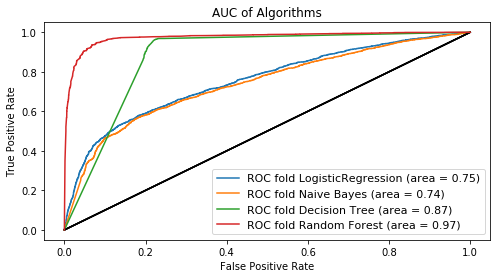

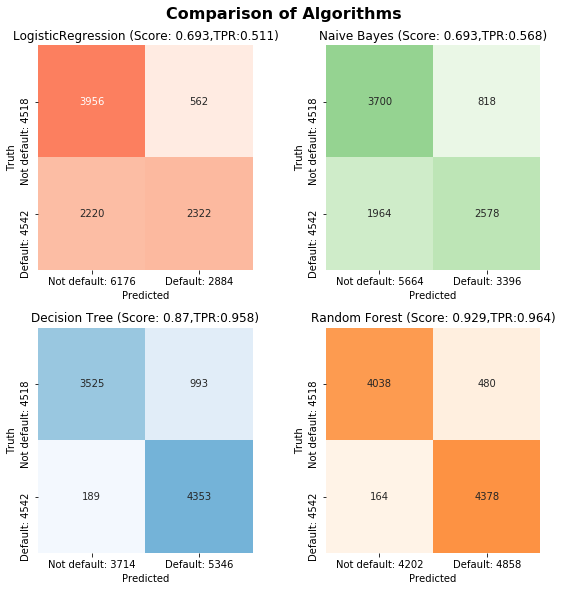

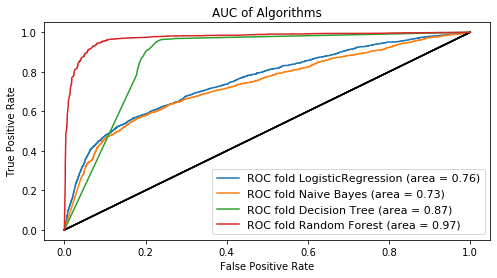

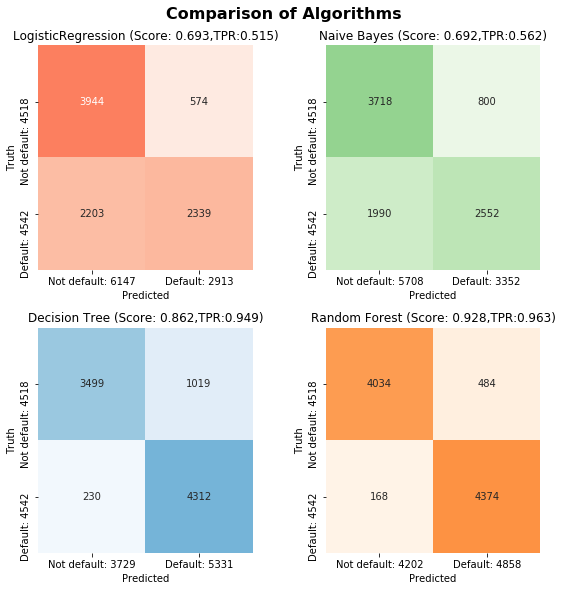

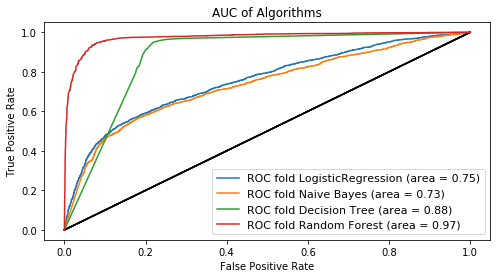

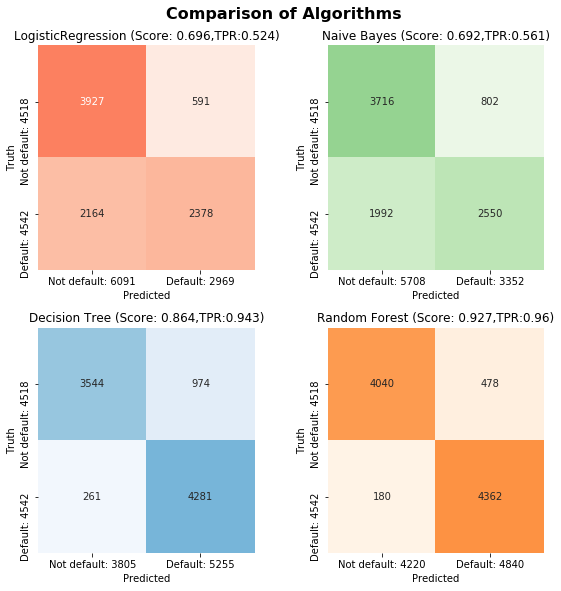

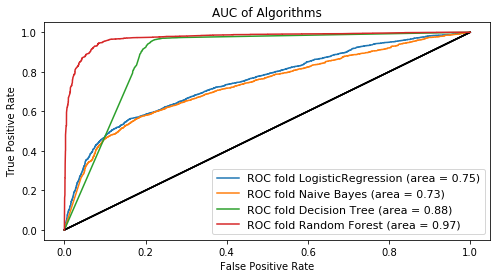

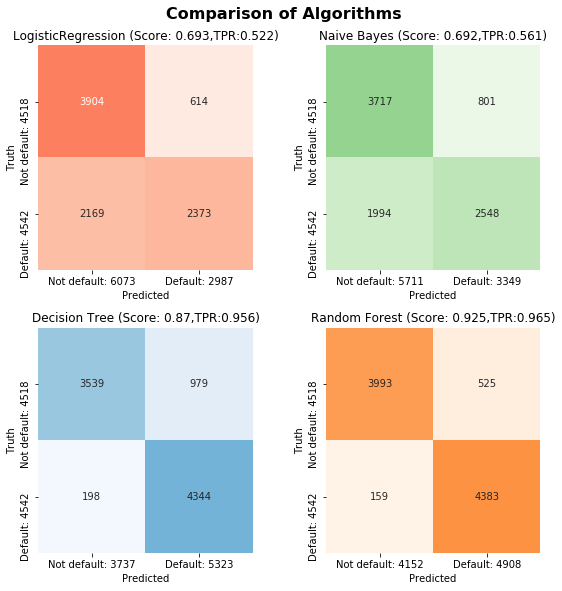

In [203]:
inputs=[dataset1, dataset2,dataset3, dataset4]
dfcomparison=[]
dfcomparison=pd.DataFrame(dfcomparison)
for ii, features in enumerate(inputs):
    dum,num=inputs[ii]
    X_train, X_test, y_train, y_test=inputsprocessing(dum,df,num)
    fig, confmatrix, valuation  = comparemodels()
    plt.suptitle('Comparison of Algorithms', y=1.02, size=16, weight='bold')
    plt.tight_layout()
    #temp=['dataset',str(ii+1)]
    #temp=''.join(temp)
    #valuation['inputs']=temp  
    dfcomparison=pd.concat([dfcomparison,valuation],axis=1) 


In [204]:
dfcomparison

,precision_score,recall,f1_score,precision_score,recall,f1_score,precision_score,recall,f1_score,precision_score,recall,f1_score
LogisticRegression,0.81,0.51,0.63,0.80,0.51,0.63,0.80,0.52,0.63,0.79,0.52,0.63
Naive Bayes,0.76,0.57,0.65,0.76,0.56,0.65,0.76,0.56,0.65,0.76,0.56,0.65
Decision Tree,0.81,0.96,0.88,0.81,0.95,0.87,0.81,0.94,0.87,0.82,0.96,0.88
Random Forest,0.90,0.96,0.93,0.90,0.96,0.93,0.90,0.96,0.93,0.89,0.96,0.93


In [205]:
dfcomparison.to_csv('Input comparison.csv', index = False)

## Step 6. Model Optimization

Random forest has the advantage of calculating the importance of features, so it can be used as a base model for feature selection to reduce the dimension and eliminate noises.<br/>
22 indexes with feature importance greater than 0.01 are selected.

In [206]:
X_train_original, X_test_original, y_train_original, y_test_original=inputsprocessing(dataset3[0],df,dataset3[1])

clf=RandomForestClassifier()
clf.fit(X_train_original, y_train_original)
fi=pd.Series(clf.feature_importances_)
fi.index=X_train_original.columns
fi = fi.sort_values(ascending=False)
# fi = fi.head(20)
#fi=fi.head(40)

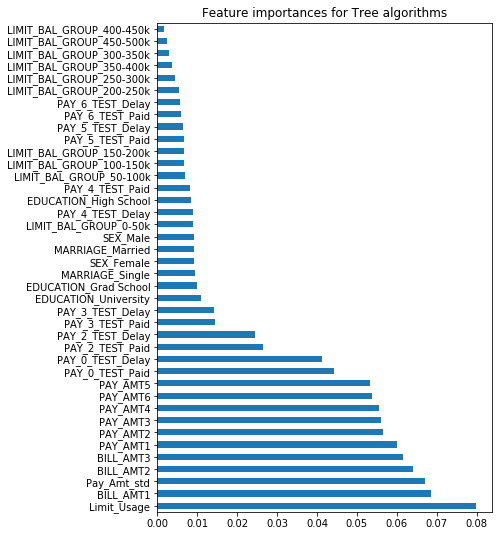

In [207]:
fi.plot.barh(title = 'Feature importances for Tree algorithms', figsize = (6,9))

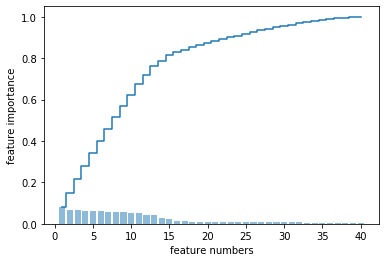

In [208]:
plt.bar(range(1, 41), fi.values, alpha=0.5, align='center')
plt.step(range(1, 41), np.cumsum(fi.values), where='mid')
plt.ylabel('feature importance')
plt.xlabel('feature numbers')
plt.show()

Test set score:0.56
Best parameters:{'C': 0.001}
Best score on train set:0.56
Test set score:0.56
Best parameters:{}
Best score on train set:0.55
Test set score:0.67
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.66
Test set score:0.78
Best parameters:{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 30}
Best score on train set:0.77
Test set score:0.58
Best parameters:{'C': 0.001}
Best score on train set:0.57
Test set score:0.56
Best parameters:{}
Best score on train set:0.55
Test set score:0.79
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.78
Test set score:0.83
Best parameters:{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 30}
Best score on train set:0.82
Test set score:0.58
Best parameters:{'C': 0.001}
Best score on train set:0.58
Test set score:0.56
Best parameters:{}
Best score on train set:0.55
Test set score:0.84
Best parameters:{'criterion': 'gini', 'max_depth': 25}
Best score on train set:0.82
Te

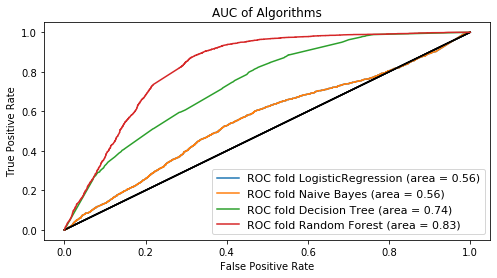

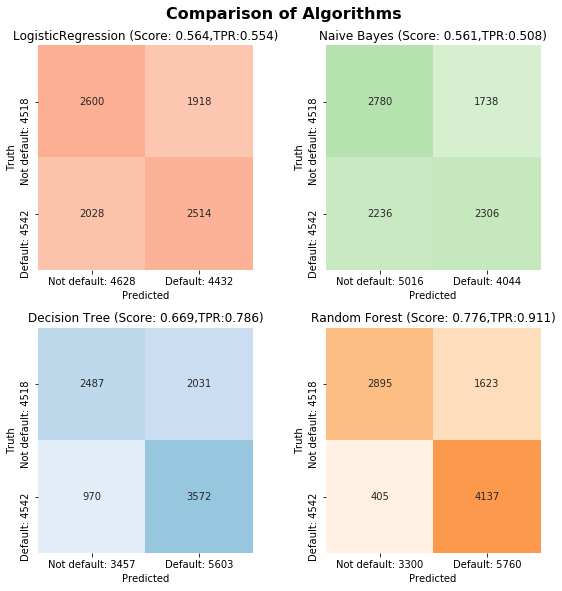

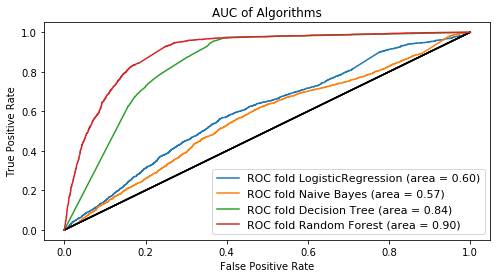

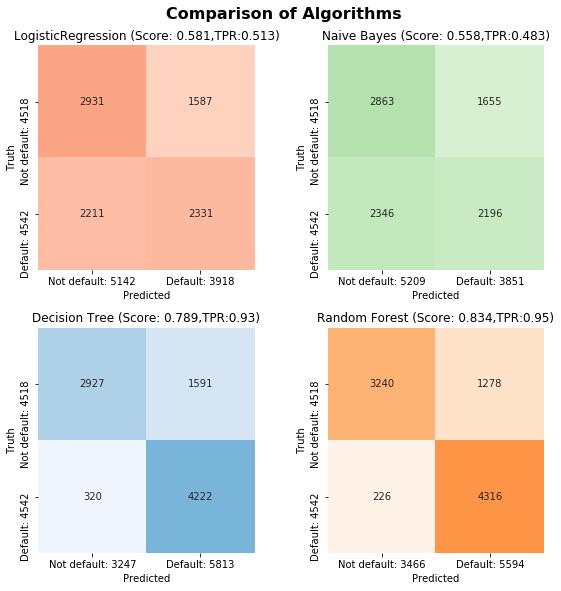

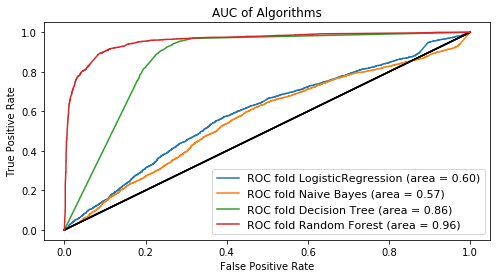

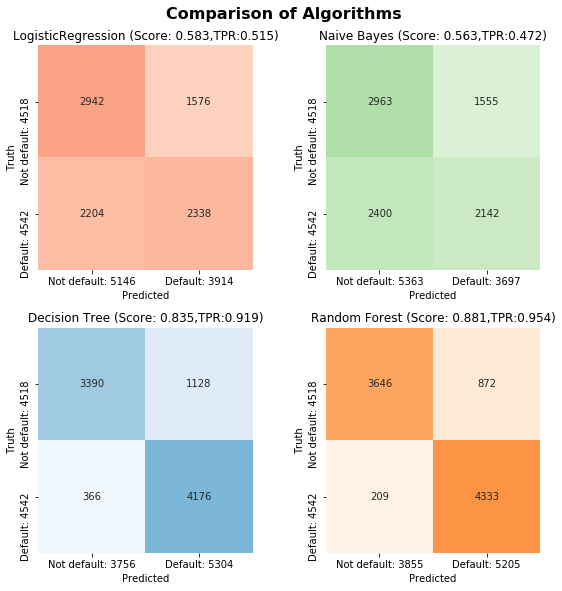

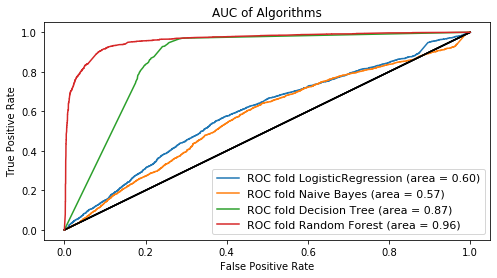

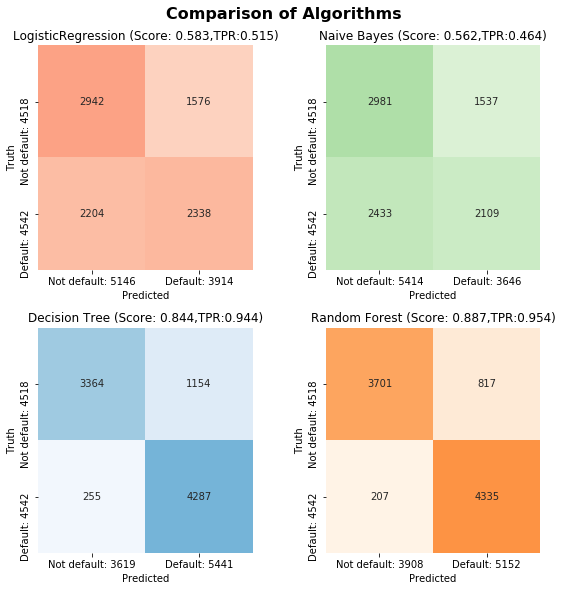

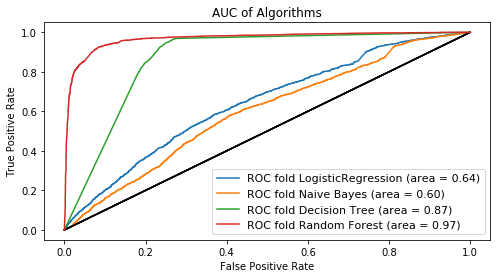

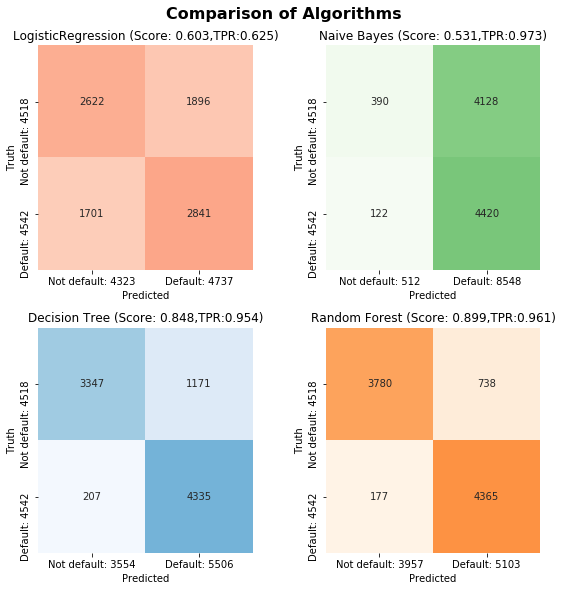

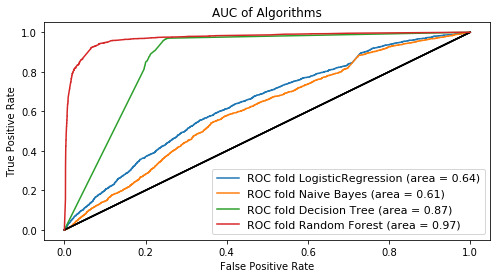

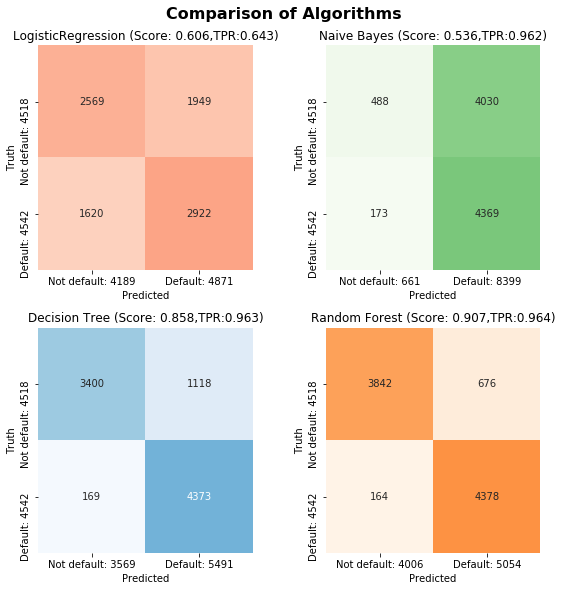

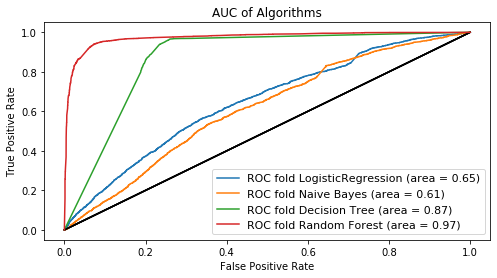

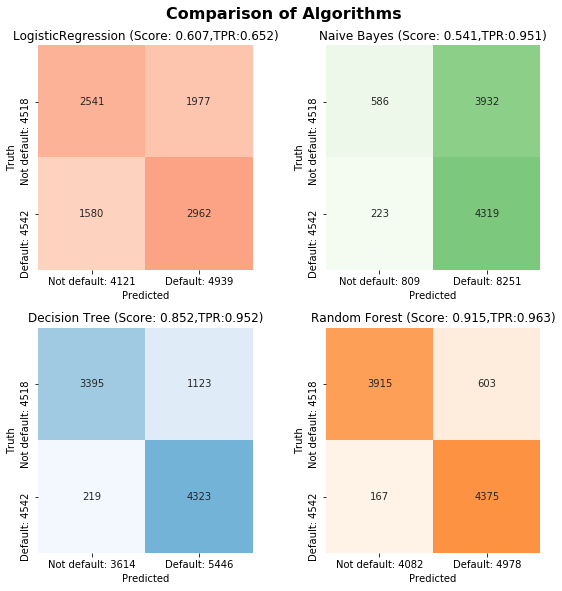

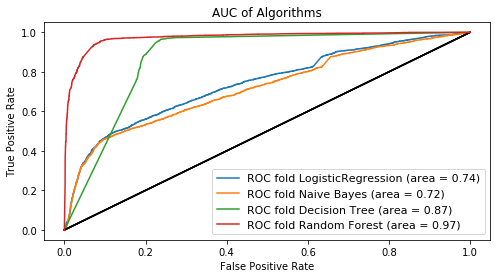

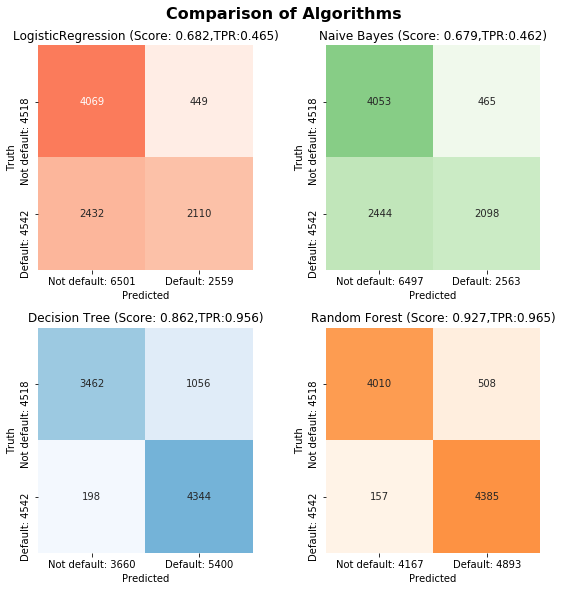

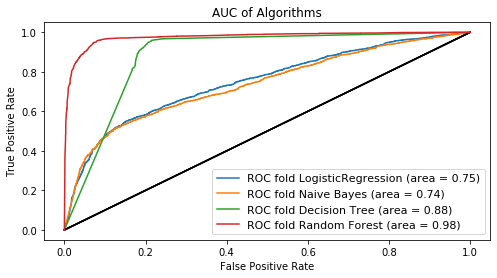

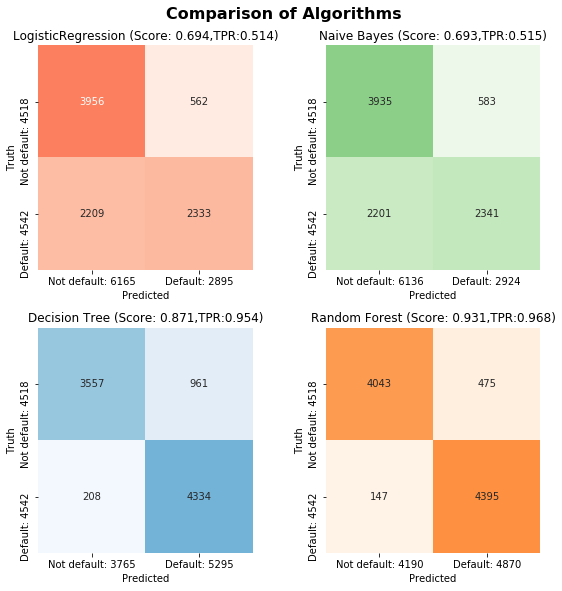

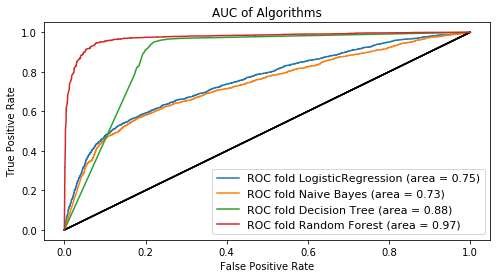

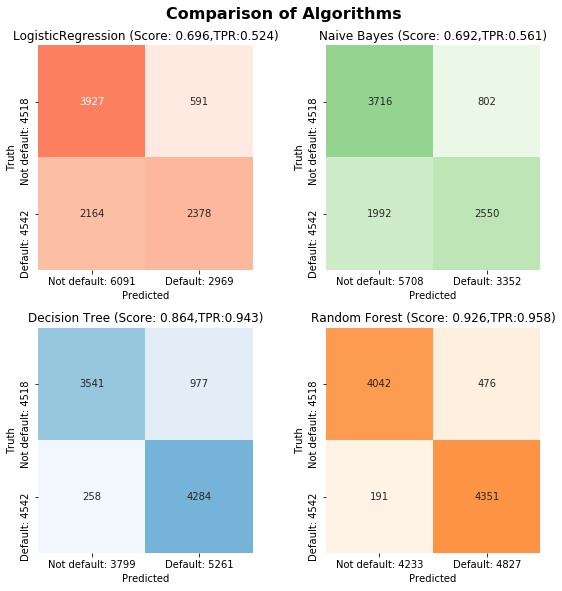

In [209]:
dfcomparison=[]
dfcomparison=pd.DataFrame(dfcomparison)
for ii in np.arange(0.1,1.1,0.1):    
    temp=np.cumsum(fi.values)
    fi_temp = fi.head(np.max(np.where(temp<=ii))+1)
    
    X_train=X_train_original[fi_temp.index]
    X_test=X_test_original[fi_temp.index]

    fig, confmatrix, valuation = comparemodels()
    valuation['cumulative importance']=ii
    plt.suptitle('Comparison of Algorithms', y=1.02, size=16, weight='bold')
    plt.tight_layout()
    
    dfcomparison=pd.concat([dfcomparison,valuation]) 
    
    

In [213]:
dfcomparison.loc['Random Forest']

,precision_score,recall,f1_score,cumulative importance
Random Forest,0.72,0.91,0.80,0.1
Random Forest,0.77,0.95,0.85,0.2
Random Forest,0.83,0.95,0.89,0.3
Random Forest,0.84,0.95,0.89,0.4
Random Forest,0.86,0.96,0.91,0.5
Random Forest,0.87,0.96,0.91,0.6
Random Forest,0.88,0.96,0.92,0.7
Random Forest,0.90,0.97,0.93,0.8
Random Forest,0.90,0.97,0.93,0.9
Random Forest,0.90,0.96,0.93,1.0


In [215]:
dfcomparison.loc['Random Forest'].to_csv('rf feature selection.csv', index = False)